# Setup

In [1]:
#***Importing libraries***

#Math tools
import numpy as np

#Patching sklearn for hardware acceleration
from sklearnex import patch_sklearn
patch_sklearn()

#Data science tools
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#OS tools
import os
import time

#Image processing tools
import cv2 

#Plotting tools
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Random seeds
np.random.seed(1)

# Custom Methods

In [3]:
### Error definition ###
def error_fn(y_true, y_pred):
    error = 0;
    for i in range(0,len(y_true)):
        if y_true[i] != y_pred[i]:
            error += 1; #Counts the number of misclassifications
    return error

# Reading the images

In [4]:
#Specifying the number of classes and images to use
n_classes = 20;
n_figs = 700;

#Specifying the total number of classes and images avaialble
N_classes = 45;
N_figs = 700;

#Randomly choosing the classes and figures to analyze
class_idx = np.random.permutation(N_classes)[:n_classes];
fig_idx = np.random.permutation(N_figs)[:n_figs]
#These two lines above generate different choices each time they're executed unless the random seed is reset

In [5]:
#Specifying the path
PROJECT_ROOT_DIR = '..'
DATASET_FOLDER = 'training_data'
DATASET_PATH = os.path.join(PROJECT_ROOT_DIR,DATASET_FOLDER)


#Reading the folders tree
classes_all = sorted(os.listdir(DATASET_PATH));
classes_all.remove('summary'); #Removes the summary file
N_classes = len(classes_all)
if n_classes > 0 and n_classes <= N_classes:
    classes = [classes_all[idx] for idx in class_idx]
else:
    print('Wrong number of classes requested')
    raise SystemExit(0)
    
#Reading the figures
figs = [];
for folder in classes:
    CLASS_PATH = os.path.join(DATASET_PATH, folder);
    figs_names_all = sorted(os.listdir(CLASS_PATH));
    if n_figs > 0 and n_figs <= N_figs:
        figs_names = [figs_names_all[idx] for idx in fig_idx]
        FIGS_PATHS = [os.path.join(CLASS_PATH, fig) for fig in figs_names]
        figs_i = [cv2.imread(PATH,0) for PATH in FIGS_PATHS]; #cv2.imread with flag 0 reads the image in grayscale
        figs.append(figs_i)
    else:
        print('Wrong number of figures requested')
        raise SystemExit(0)

#Converting into a numpy array
figs = np.array(figs);
print('figs.shape')
print(figs.shape)

##***Output***
# figs: Multidimensional numpy array containing all read images. First dimension corresponds to class and second dimension to figures. 
#Each figure is a multidimensional array itself of 256x256 pixels and only the greyscale channel: int(0,255)

figs.shape
(20, 700, 256, 256)


In [6]:
#Shows the names of the chosen classes and their corresponding indexes in figs
print('Chosen classes:')
print(list(enumerate(classes)))

Chosen classes:
[(0, 'basketball_court'), (1, 'baseball_diamond'), (2, 'railway_station'), (3, 'lake'), (4, 'meadow'), (5, 'tennis_court'), (6, 'intersection'), (7, 'sea_ice'), (8, 'runway'), (9, 'roundabout'), (10, 'wetland'), (11, 'river'), (12, 'medium_residential'), (13, 'harbor'), (14, 'rectangular_farmland'), (15, 'railway'), (16, 'ship'), (17, 'storage_tank'), (18, 'beach'), (19, 'mobile_home_park')]


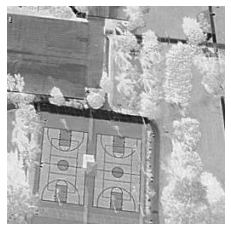

In [7]:
#Visualizing some of the data
fig_test = figs[0][0];
plt.imshow(fig_test, cmap = mpl.cm.binary); plt.axis("off");

# Preparing the data set

In [8]:
#Linearizing the input data
X = figs.reshape([n_classes*n_figs, 256, 256]); #Inputs
y = np.zeros([n_classes, n_figs], dtype=int);
for i in range (n_classes):
    for j in range(n_figs):
        y[i,j] = i;
y = y.reshape([n_classes*n_figs]); #Labels

In [9]:
#Shuffling the input data
idx_random = np.random.permutation(len(X));
X = X[idx_random,:,:];
y = y[idx_random]

10
wetland


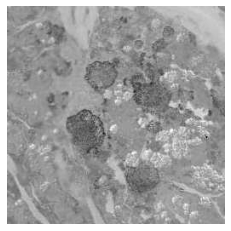

In [10]:
#Visualizing some of the data
idx = 11;
X_sample = X[idx];
plt.imshow(X_sample, cmap = mpl.cm.binary); plt.axis("off");
print(y[idx])
print(classes[y[idx]])

In [11]:
#Reshaping the dataset to a 2D array
X = X.reshape(-1, 256*256);
X.shape

(14000, 65536)

In [12]:
#Splitting the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75, random_state=0) #Optimize for classification problems
N_train = len(X_train)
N_test = len(X_test)

In [13]:
X_train.shape

(10500, 65536)

# Training the SVM classifier

In [14]:
#Setting up the models
C = 1  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.SVC(kernel='poly', degree=2, gamma='auto', C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C))
titles = ('SVM with linear kernel',
          'SVM with polynomial (degree 2) kernel',
          'SVM with polynomial (degree 3) kernel',
          'SVM with RBF kernel')
#Training 
models = (clf.fit(X_train, y_train) for clf in models)

## Training and generalization error

In [15]:
start_time = time.time()
i = 0;
error_train = np.zeros(len(titles))
error_test = np.zeros(len(titles))
print_results = True;
if print_results: print('*** Results ***')
for clf in models:       
    print(titles[i])
    #Train
    y_pred_train = clf.predict(X_train)
    error_train[i] = error_fn(y_train, y_pred_train)
    #Test
    y_pred_test = clf.predict(X_test)
    error_test[i] = error_fn(y_test, y_pred_test)
    if print_results:
        print('Train:'+str(y_pred_train))
        print('Test:'+str(y_pred_test)+'\n')
    i += 1

end_time = time.time()

if print_results:
    print('*** Truth ***')
    print('Train'+str(y_train))
    print('Test'+str(y_test))

print('\n*** Training error ***')
print('N_train: '+str(N_train))
i = 0
for title in titles:
    print(title+': %d (%0.1f%%)'%(error_train[i],error_train[i]/N_train*100))
    i += 1
print('\n*** Generalization error ***')
print('N_test: '+str(N_test))
i = 0
for title in titles:
    print(title+': %d (%0.1f%%)'%(error_test[i],error_test[i]/N_test*100))
    i += 1
    
print('\n Execution time %0.2f s'%(end_time-start_time))

*** Results ***
SVM with linear kernel
Train:[16 14 10 ... 10  9  0]
Test:[3 3 7 ... 0 3 2]

SVM with polynomial (degree 2) kernel
Train:[16 14 10 ... 10  9  0]
Test:[16  4  1 ...  9 15  2]

SVM with polynomial (degree 3) kernel
Train:[16 14 10 ... 10  9  0]
Test:[16  5  1 ...  9 15  2]

SVM with RBF kernel
Train:[16 14 10 ... 10  9  0]
Test:[8 8 8 ... 8 8 8]

*** Truth ***
Train[16 14 10 ... 10  9  0]
Test[13 12 19 ...  5  6  6]

*** Training error ***
N_train: 10500
SVM with linear kernel: 0 (0.0%)
SVM with polynomial (degree 2) kernel: 0 (0.0%)
SVM with polynomial (degree 3) kernel: 0 (0.0%)
SVM with RBF kernel: 0 (0.0%)

*** Generalization error ***
N_test: 3500
SVM with linear kernel: 2983 (85.2%)
SVM with polynomial (degree 2) kernel: 2918 (83.4%)
SVM with polynomial (degree 3) kernel: 2959 (84.5%)
SVM with RBF kernel: 3350 (95.7%)

 Execution time 3374.00 s


> ***The model is clearly overfitted!!!!***

# Best k-rank approximation through PCA

**Key questions**
- How to efficiently apply SVD to a batch of images and make decision about the number of modes to use? 
- Do we apply SVD to each input image, each class, or to the training dataset as a whole?
- What could be the optimum number of principal components to use? Which metric do we use to compare them?
- Training the model with the reduced components turned out to be much more computationall y expensive than training with the raw images. Why???

In [16]:
pca = PCA();
X_train_centered = X_train - X_train.mean(axis=0) # Test dataset
pca.fit(X_train_centered)
cumsum = np.cumsum(pca.explained_variance_ratio_)  #Note that the max number of singular values is the number of images in X_train
threshold = 0.95;
d = np.argmax(cumsum >= threshold) + 1

In [17]:
d

3285

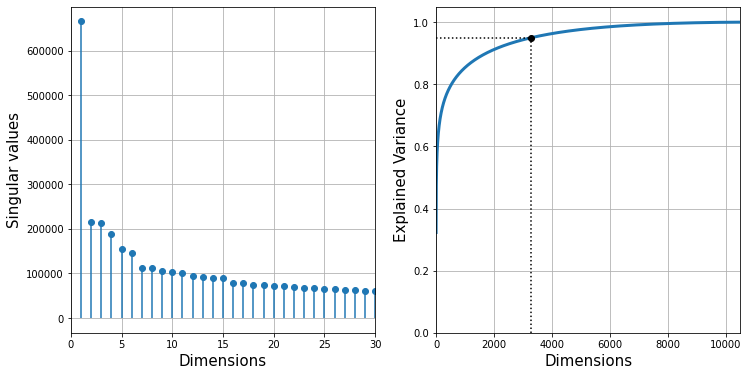

In [18]:
fig, subplt = plt.subplots(1, 2, figsize=(12, 6))

ax = subplt[0];
#ax.semilogy(range(1,len(cumsum)+1),(pca.singular_values_), 'o', linewidth=3)
ax.stem(range(1,len(cumsum)+1),(pca.singular_values_),basefmt=' ')
ax.set_xlabel("Dimensions", fontsize=15)
ax.set_ylabel("Singular values", fontsize=15)
ax.set_xlim([0,30])
ax.grid(True)


ax = subplt[1];
ax.plot(range(1,len(cumsum)+1),cumsum, linewidth=3)
ax.set_xlabel("Dimensions", fontsize=15)
ax.set_ylabel("Explained Variance", fontsize=15)

ax.plot([d, d], [0, threshold], "k:")
ax.plot([0, d], [threshold, threshold], "k:")
ax.plot(d, threshold, "ko")
ax.set_ylim([0,1.05])
ax.set_xlim([0,len(cumsum)+1])
ax.grid(True)



plt.show()

In [19]:
start_time = time.time()

pca = PCA(n_components=0.95)
X_train_centered = X_train - X_train.mean(axis=0) # Test dataset
X_train_reduced = pca.fit_transform(X_train)
X_train_recovered = pca.inverse_transform(X_train_reduced)

end_time = time.time()
print('\n Execution time %0.2f s'%(end_time-start_time))


 Execution time 651.19 s


In [20]:
pca.n_components_

3285

In [21]:
np.sum(pca.explained_variance_ratio_)

0.9500207554073652

In [22]:
### Projecting the rest of the data onto the PCs of the training data ###
#Centers the data
X_centered = X - X.mean(axis=0) # Whole dataset
X_test_centered = X_test - X_test.mean(axis=0) # Test dataset
#Extract the normal vectors of the principal components
V_r = np.transpose(pca.components_); #pca.components = V^T
#Projects the data
X_reduced = np.matmul(X_centered, V_r);
X_test_reduced = np.matmul(X_test_centered, V_r)
X_test_recovered = pca.inverse_transform(X_test_reduced) #Equivalent to: np.matmul(X_test_reduced,np.transpose(V_r))

In [23]:
X_train_recovered.shape

(10500, 65536)

meadow


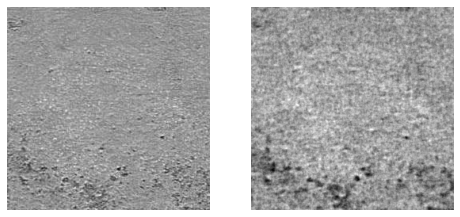

In [24]:
#Visualizing some of the data - TRAINING
idx = 50;
#Train
X_sample = X_train[idx].reshape(256,256);
X_sample_recons = X_train_recovered[idx].reshape(256,256);
print(classes[y_train[idx]])
#Plotting
fig, sub = plt.subplots(1, 2, figsize=(8, 6))
sub[0].imshow(X_sample, cmap = mpl.cm.binary); sub[0].axis("off");
sub[1].imshow(X_sample_recons, cmap = mpl.cm.binary); sub[1].axis("off");

harbor


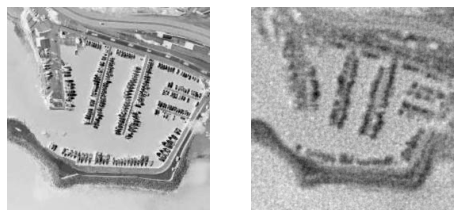

In [25]:
#Visualizing some of the data - TEST
idx = 10;
#Test
X_sample = X_test[idx].reshape(256,256);
X_sample_recons = X_test_recovered[idx].reshape(256,256);
print(classes[y_test[idx]])
#Plotting
fig, sub = plt.subplots(1, 2, figsize=(8, 6))
sub[0].imshow(X_sample, cmap = mpl.cm.binary); sub[0].axis("off");
sub[1].imshow(X_sample_recons, cmap = mpl.cm.binary); sub[1].axis("off");

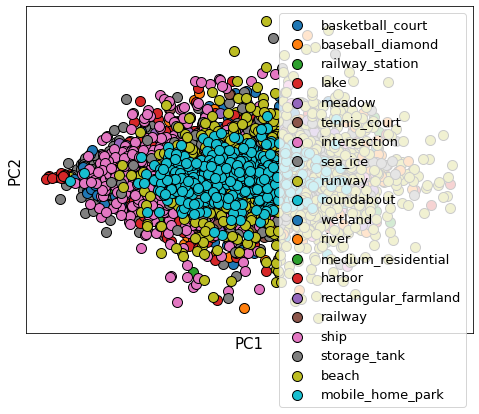

In [26]:
#Vizualizing the data in based on the first two principal components
X0, X1 = X_reduced[:, 0], X_reduced[:, 1];
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
for g in np.unique(y):
    idx = np.where(y == g);
    ax.scatter(X0[idx], X1[idx], s=100, edgecolors='k', label=classes[g])
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_xticks(())
ax.set_yticks(())
ax.legend(fontsize=13)
plt.show()

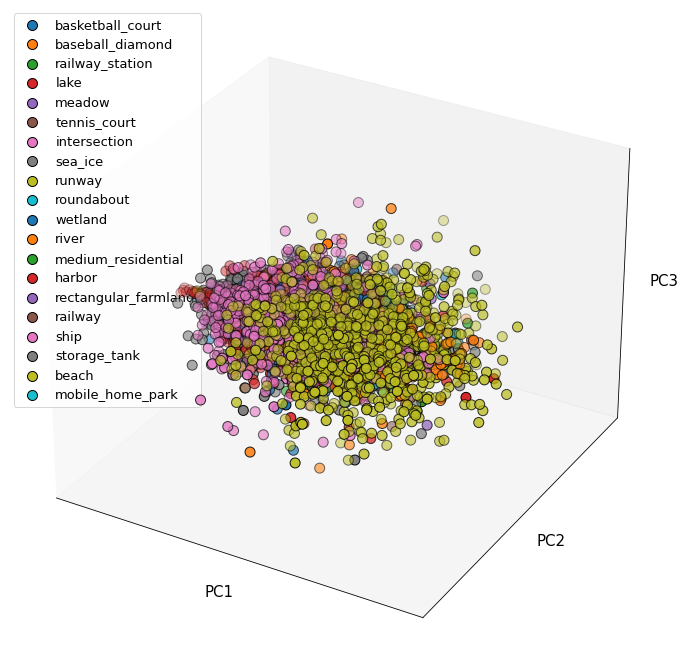

In [27]:
#Vizualizing the data in based on the first three principal components
X0, X1, X2 = X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2];
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
for g in np.unique(y):
    idx = np.where(y == g);
    ax.scatter(X0[idx], X1[idx], X2[idx], s=100, edgecolors='k', label=classes[g])
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)
ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())
ax.legend(fontsize=13)

#ax.view_init(80, angle)

plt.show()


# Training the SVM classifier on the reduced space

In [28]:
#Setting up the models
C = 1  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.SVC(kernel='poly', degree=2, gamma='auto', C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C))
titles = ('SVM with linear kernel',
          'SVM with polynomial (degree 2) kernel',
          'SVM with polynomial (degree 3) kernel',
          'SVM with RBF kernel')
#Training 
models = (clf.fit(X_train_reduced, y_train) for clf in models)

## Training and generalization error

In [29]:
start_time = time.time()
i = 0;
error_train = np.zeros(len(titles))
error_test = np.zeros(len(titles))
print_results = True;
if print_results: print('*** Results ***')
for clf in models:       
    print(titles[i])
    #Train
    y_pred_train = clf.predict(X_train_reduced)
    error_train[i] = error_fn(y_train, y_pred_train)
    #Test
    y_pred_test = clf.predict(X_test_reduced)
    error_test[i] = error_fn(y_test, y_pred_test)
    if print_results:
        print('Train:'+str(y_pred_train))
        print('Test:'+str(y_pred_test)+'\n')
    i += 1

end_time = time.time()

if print_results:
    print('*** Truth ***')
    print('Train'+str(y_train))
    print('Test'+str(y_test))

print('\n*** Training error ***')
print('N_train: '+str(N_train))
i = 0
for title in titles:
    print(title+': %d (%0.1f%%)'%(error_train[i],error_train[i]/N_train*100))
    i += 1
print('\n*** Generalization error ***')
print('N_test: '+str(N_test))
i = 0
for title in titles:
    print(title+': %d (%0.1f%%)'%(error_test[i],error_test[i]/N_test*100))
    i += 1
    
print('\n Execution time %0.2f s'%(end_time-start_time))

*** Results ***
SVM with linear kernel
Train:[16 14 10 ... 10  9  0]
Test:[3 5 1 ... 0 3 2]

SVM with polynomial (degree 2) kernel
Train:[16 14 10 ... 10  9  0]
Test:[18 11 15 ... 14  8  4]

SVM with polynomial (degree 3) kernel
Train:[16 14 10 ... 10  9  0]
Test:[ 5 14  4 ...  4  4  4]

SVM with RBF kernel
Train:[16 14 10 ... 10  9  0]
Test:[8 8 8 ... 8 8 8]

*** Truth ***
Train[16 14 10 ... 10  9  0]
Test[13 12 19 ...  5  6  6]

*** Training error ***
N_train: 10500
SVM with linear kernel: 0 (0.0%)
SVM with polynomial (degree 2) kernel: 0 (0.0%)
SVM with polynomial (degree 3) kernel: 0 (0.0%)
SVM with RBF kernel: 0 (0.0%)

*** Generalization error ***
N_test: 3500
SVM with linear kernel: 2999 (85.7%)
SVM with polynomial (degree 2) kernel: 2979 (85.1%)
SVM with polynomial (degree 3) kernel: 2993 (85.5%)
SVM with RBF kernel: 3350 (95.7%)

 Execution time 137.68 s


# Reduced input space through random projection (maybe?)

**Key questions**
- What kind of information/improvements would we get this way compared to PCA?

In [30]:
<code>

SyntaxError: invalid syntax (<ipython-input-30-2368be27b780>, line 1)

# Cool ways to visualize the performance of the classifier

**Ideas**
- Manually add noise/perturbations to the images to test the classfier under extreme scenarios
- We could augment our training data set this way too! Do we need more data or are 700 images per class enough?
- Could we extende the trained model to be interactive such that we can upload a picture and it gets classified instantly?

In [ ]:
<code>